In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt


import sys
sys.path.append("../../../../")

from src.difsched.agents.DiffusionQL.DQL_Q_esmb import DQL_Q_esmb as Agent
from src.difsched.utils.DataSampler import ReplayBuffer
from toy_gaussian_helper import create_toy_gaussian_dataset, eval

In [4]:

hyperparams = {
    'N_diffusion_steps': 10,
    'schedule_type': "vp",
    'approximate_action': True,
    'gamma': 0.99,
    'abs_action_max': 1.0,
    'lr': 6e-4,
    'decay_lr': False,
    'weight_decay': 0.001,
    'num_critics': 4,
    'lcb_coef': 0.1,
    'max_q_backup': True,
    'weight_entropy_loss': 0.01,
    'weight_q_loss': 1.0,
    'ema_tau': 0.005,
    'ema_period': 20,
    'ema_begin_update': 1000,
    'device': "cuda",
}


rb_capacity =5000
dataset = create_toy_gaussian_dataset(N_samples=rb_capacity)

data_sampler = ReplayBuffer(capacity=rb_capacity, device=hyperparams['device'])
data_sampler.add(dataset)

Iteration 0, Ld: 1.0131187313199044, Lq: 3.020188778809039, Le: -0.8256783521771431, loss_Q: 1.6726593533456326


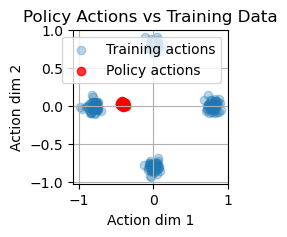

Iteration 1, Ld: 0.8587140795588494, Lq: 2.6209232354164125, Le: -0.8220883057713508, loss_Q: 0.5755653710961341


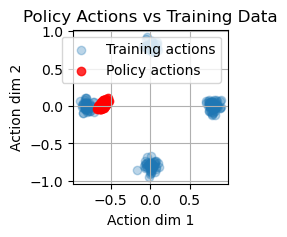

Iteration 2, Ld: 0.6038272841572762, Lq: 2.500869787096977, Le: -0.7695206544399261, loss_Q: 0.5601751752495766


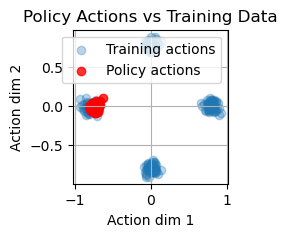

KeyboardInterrupt: 

In [5]:
modelFolder = f'../../../../data/results/examples/mixture_gaussian'

agent = Agent(state_dim=1, action_dim=2, **hyperparams)

iterations = 1000
batch_size = 100
N_episodes = 4
for i in range(N_episodes):
    metrics = agent.train(data_sampler, iterations, batch_size, tqdm_pos=0)
    print(f"Iteration {i}, Ld: {np.mean(metrics['Ld'])}, " + 
          f"Lq: {np.mean(metrics['Lq'])}, " + 
          f"Le: {np.mean(metrics['Le'])}, " + 
          f"loss_Q: {np.mean(metrics['loss_Q'])}")
    eval(agent, sample_method="EAS", N_eval=200, N_sample=10, eta=0.01, figsize=(2, 2))
    agent.save_model(modelFolder, i)

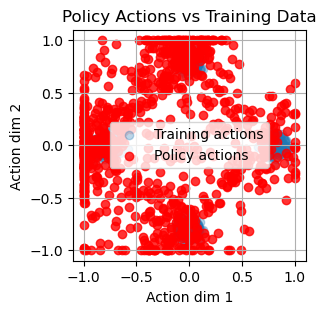

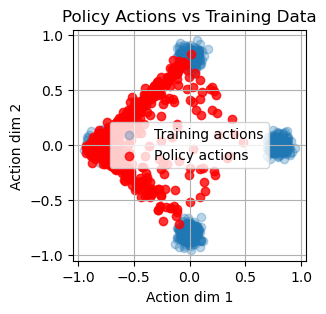

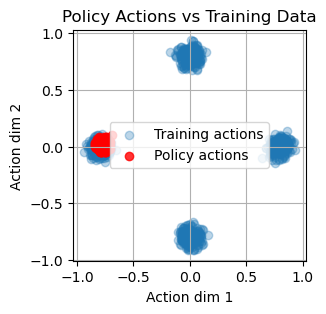

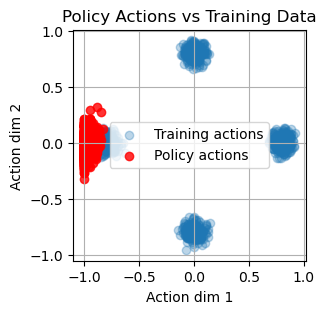

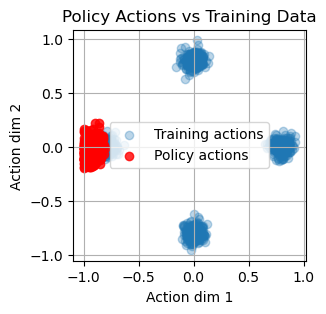

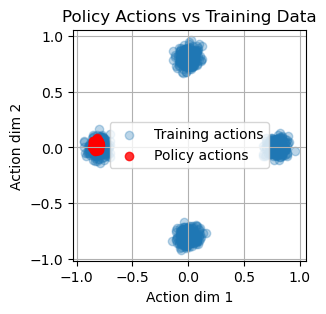

In [6]:
EAS_data = {'train_01':[], 'train_02':[], 'train_03':[], 'eval_01':[], 'eval_02':[], 'eval_03':[]}
EAS_data['train_01'], EAS_data['eval_01'] = eval(agent, N_eval=1000, sample_method="EAS", N_sample=20, eta=5.0, figsize=(3, 3))
EAS_data['train_02'], EAS_data['eval_02'] = eval(agent, N_eval=1000, sample_method="EAS", N_sample=20, eta=0.2, figsize=(3, 3))
EAS_data['train_03'], EAS_data['eval_03'] = eval(agent, N_eval=1000, sample_method="EAS", N_sample=20, eta=0.01, figsize=(3, 3))

greedy_data = {'train_01':[], 'train_02':[], 'train_03':[], 'eval_01':[], 'eval_02':[], 'eval_03':[]}
greedy_data['train_01'], greedy_data['eval_01'] = eval(agent, N_eval=1000, sample_method="greedy", N_sample=20, eta=1.5, figsize=(3, 3))
greedy_data['train_02'], greedy_data['eval_02'] = eval(agent, N_eval=1000, sample_method="greedy", N_sample=20, eta=0.5, figsize=(3, 3))
greedy_data['train_03'], greedy_data['eval_03'] = eval(agent, N_eval=1000, sample_method="greedy", N_sample=20, eta=0.01, figsize=(3, 3))


import pickle
with open(f'{modelFolder}/EAS_data.pkl', 'wb') as f:
    pickle.dump(EAS_data, f)

with open(f'{modelFolder}/greedy_data.pkl', 'wb') as f:
    pickle.dump(greedy_data, f) 